In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import os
from glob import glob
from scipy.io import loadmat

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

from tensorflow import keras
from keras import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import VGG16

import tensorflow as tf
import tensorflow_addons.losses.giou_loss as GIoU_Loss

from tqdm.auto import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import cv2

import re

from skimage import io

from typing import Optional, Union, List, Tuple, ByteString, Dict

In [2]:
train_data = pd.read_csv('train.csv', dtype=str).dropna()
train_data.head()

,ruta_archivo,x1,y1,x2,y2,valencia,excitacion,dominancia
0,mscoco/images/COCO_val2014_000000562243.jpg,86,58,564,628,5,3,9
1,mscoco/images/COCO_train2014_000000288841.jpg,485,149,605,473,6,4,7
2,mscoco/images/COCO_val2014_000000558171.jpg,305,92,461,465,7,8,8
3,mscoco/images/COCO_train2014_000000369575.jpg,221,63,448,372,8,9,8
4,mscoco/images/COCO_train2014_000000213009.jpg,44,143,150,288,7,9,10


In [3]:
val_data = pd.read_csv('val.csv', dtype=str).dropna()
val_data.head()

,ruta_archivo,x1,y1,x2,y2,valencia,excitacion,dominancia
0,mscoco/images/COCO_val2014_000000020459.jpg,109,108,401,450,4,8,5
1,mscoco/images/COCO_val2014_000000033835.jpg,404,222,563,473,6,4,7
2,emodb_small/images/arhnymaeequumexga8.jpg,2,2,370,266,5,6,6
3,mscoco/images/COCO_train2014_000000535817.jpg,149,89,425,351,6,5,6
4,mscoco/images/COCO_val2014_000000187857.jpg,291,32,489,349,6,7,6


In [4]:
test_data = pd.read_csv('test.csv', dtype=str).dropna()
test_data.head()

,ruta_archivo,x1,y1,x2,y2,valencia,excitacion,dominancia
0,framesdb/images/frame_ghkq7yp0itqz0kn7.jpg,279,18,623,425,7,4,6
1,mscoco/images/COCO_train2014_000000537379.jpg,229,106,392,363,5,6,7
2,mscoco/images/COCO_train2014_000000049309.jpg,183,147,324,421,6,7,7
3,mscoco/images/COCO_train2014_000000353994.jpg,234,78,348,373,6,9,7
4,mscoco/images/COCO_train2014_000000336491.jpg,375,19,534,398,6,6,5


In [5]:
def visualize_subplot(imgs: List[np.ndarray], titles: List[str], division: Tuple[int], figsize: Tuple[int] = None, cmap: str = "gray"):
    fig: plt.Figure = plt.figure(figsize=figsize)
    if figsize:
        fig.set_figwidth(figsize[0])
        fig.set_figheight(figsize[1])

    assert len(imgs) == len(titles), "La lista de imágenes y de títulos debe ser del mismo tamaño"
    assert np.prod(division) >= len(imgs)

    for index, title in enumerate(titles):
        ax: plt.Axes = fig.add_subplot(division[0], 
                            division[1], index+1)
        ax.imshow(imgs[index], cmap=cmap)
        ax.set_title(title)
        plt.axis("off")

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_data[['ruta_archivo','x1','y1','x2','y2','valencia','excitacion','dominancia']])
train_list_ds = train_list_ds.shuffle(len(train_list_ds), reshuffle_each_iteration=False)

val_list_ds = tf.data.Dataset.from_tensor_slices(val_data[['ruta_archivo','x1','y1','x2','y2','valencia','excitacion','dominancia']])
val_list_ds = train_list_ds.shuffle(len(val_list_ds), reshuffle_each_iteration=False)

test_list_ds = tf.data.Dataset.from_tensor_slices(test_data[['ruta_archivo','x1','y1','x2','y2','valencia','excitacion','dominancia']])
test_list_ds = train_list_ds.shuffle(len(test_list_ds), reshuffle_each_iteration=False)

In [7]:
BATCH_SIZE = 64
TRAIN_SIZE = len(train_list_ds)
VAL_SIZE = len(val_list_ds)
TEST_SIZE = len(test_list_ds)
SIZE = (200, 200)

In [8]:
@tf.function
def parse_ds_function(example_input: Optional[tf.Tensor],) -> Optional[Tuple[tf.Tensor]]:
    image = tf.io.read_file(example_input[0])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.
    
    x1 = tf.strings.to_number(example_input[1])
    y1 = tf.strings.to_number(example_input[2])
    x2 = tf.strings.to_number(example_input[3])
    y2 = tf.strings.to_number(example_input[4])
    
    shape = tf.shape(image)    
    image = tf.image.resize(image, SIZE)
    x_scale = 200. / tf.cast(shape[1], tf.float32)
    y_scale = 200. / tf.cast(shape[0], tf.float32)

    bbox = [tf.round(y1 * y_scale),
            tf.round(x1 * x_scale),
            tf.round(y2 * y_scale),
            tf.round(x2 * x_scale),]
    
    val = tf.strings.to_number(example_input[5])
    exc = tf.strings.to_number(example_input[6])
    dom = tf.strings.to_number(example_input[7])

    return image, bbox, [val, exc, dom], example_input[0]

In [9]:
train_ds = train_list_ds.map(parse_ds_function)
val_ds = val_list_ds.map(parse_ds_function)
test_ds = test_list_ds.map(parse_ds_function)

In [10]:
def performance(dataset: Optional[tf.data.Dataset], train: bool = True,) -> Optional[tf.data.Dataset]:
    if train:
        dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [11]:
train_ds = performance(train_ds)
val_ds = performance(val_ds, False)
test_ds = performance(test_ds, False)

In [13]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(*SIZE, 3)))
vgg.trainable = False

flatten_bbox = Flatten()(vgg.output)
dense_1_bbox = Dense(128, activation = 'relu')(flatten_bbox)
dense_2_bbox = Dense(32, activation = 'relu')(dense_1_bbox)
output_bbox = Dense(4, activation = lambda x: 200*tf.keras.activations.sigmoid(x))(dense_2_bbox)
model_bbox_base = Model(inputs = vgg.inputs, outputs = output_bbox)

model_bbox_base.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss = 'mse')
model_bbox_base.load_weights('modelo_bbox_mse_weights')

In [14]:
inception = keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(*SIZE, 3),)
inception.trainable = False

flatten_emo = Flatten()(inception.output)
dense_1_emo = Dense(128, activation = 'relu')(flatten_emo)
dense_2_emo = Dense(32, activation = 'relu')(dense_1_emo)
output_emo = Dense(3, activation = lambda x: 10*tf.keras.activations.sigmoid(x))(dense_2_emo)
model_reg_base = Model(inputs = inception.inputs, outputs = output_emo)

model_reg_base.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss = 'mse')
model_reg_base.load_weights('modelo_reg_mse_weights')

In [24]:
for X_batch, y_batch_bbox, y_batch_reg, rutas_batch in test_ds.take(1):
    break
np.random.seed(7)
random_sample = np.random.choice(len(X_batch), 8)
X_img = X_batch.numpy()[random_sample]
y_reg = y_batch_reg.numpy()[random_sample]
y_reg_pred = model_reg_base.predict(X_img)
y_bboxs = y_batch_bbox.numpy()[random_sample]
y_bboxs_pred = model_bbox_base.predict(X_img)
rutas = rutas_batch.numpy()[random_sample]

In [25]:
imgs = []
labels = []
for img, reg, pred_reg, bbox, pred_bbox, ruta in zip(X_img, y_reg, y_reg_pred, y_bboxs, y_bboxs_pred, rutas):
    new_img = cv2.rectangle(img, (int(bbox[1]), int(bbox[0])), (int(bbox[3]), int(bbox[2])), (1, 0, 0), 3)
    new_img = cv2.rectangle(new_img, (int(pred_bbox[1]), int(pred_bbox[0])), (int(pred_bbox[3]), int(pred_bbox[2])), (0, 0, 1), 3)
    str_real = "\nReal: Val: " + str(round(reg[0])) + "; Exc: " + str(round(reg[1])) + "; Dom: " + str(round(reg[2]))
    str_pred = "\nPred: Val: " + str(round(pred_reg[0])) + "; Exc: " + str(round(pred_reg[1])) + "; Dom: " + str(round(pred_reg[2]))
    imgs.append(new_img)
    labels.append(str(ruta) + str_real + str_pred)

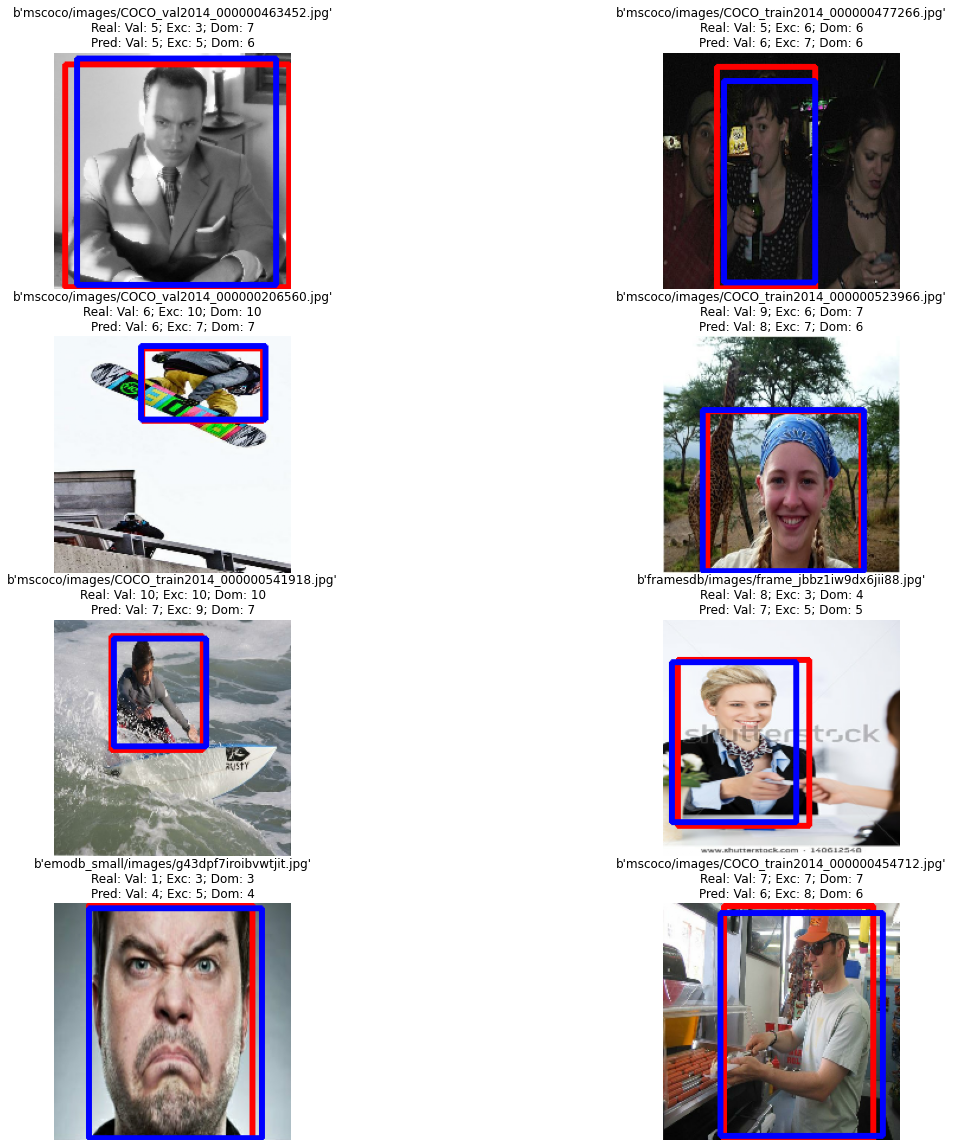

In [26]:
visualize_subplot(imgs, labels, (4, 2), (20, 20),)